In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression

In [4]:
# options_data = pd.read_csv("train_files/options.csv")
# options_data.head()

In [5]:
trades_data = pd.read_csv("train_files/stock_prices.csv")
trades_data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [7]:
num_secs = trades_data.SecuritiesCode.unique().size
num_dates = trades_data.Date.unique().size
print("Data found for {} securities for roughly {} dates".format(num_secs, num_dates))

Data found for 2000 securities for roughly 1202 dates


In [19]:
data = trades_data[trades_data["SecuritiesCode"] == 1301]
data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
3730,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092
5595,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100
7460,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295


In [20]:
# Removing data point having NaN close px
data = data[~data["Close"].isna()]
len(data)

1201

## Preliminary Data Analysis

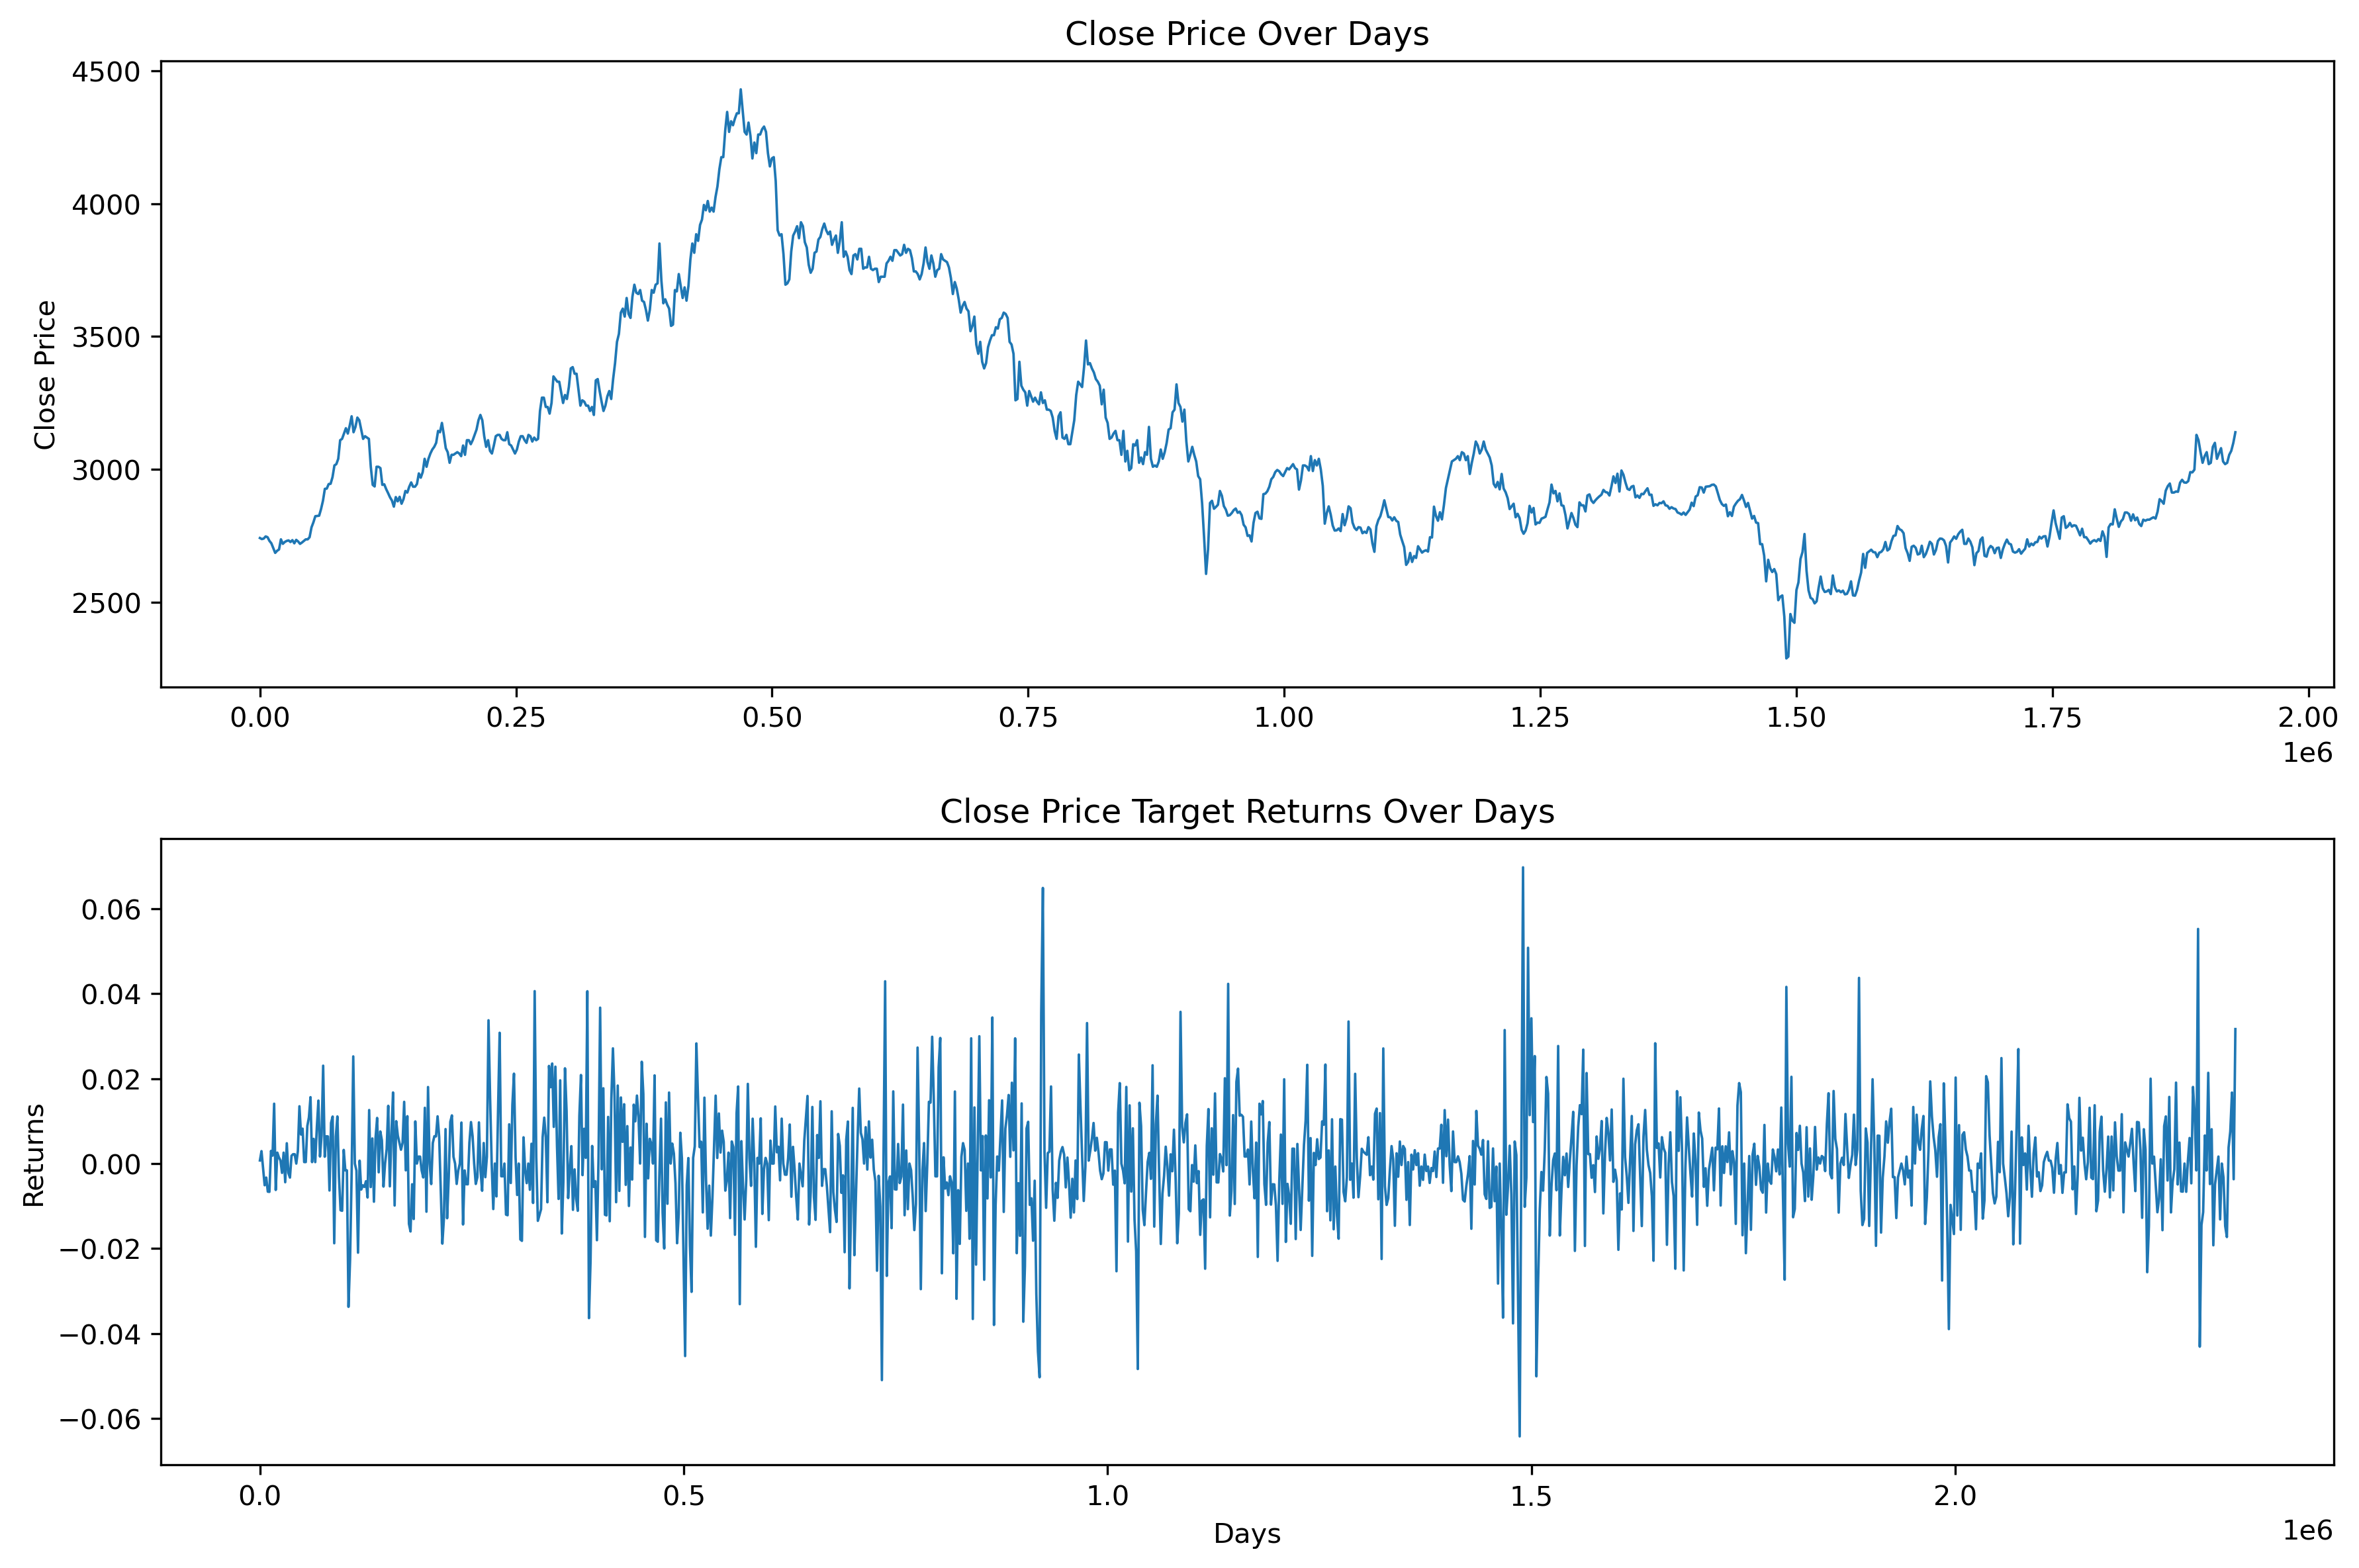

In [120]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), dpi=300)

ax = axes[0]
ax.plot(train_data["Close"], linewidth=0.9)
ax.set_title('Close Price Over Days')
ax.set_ylabel("Close Price")

ax = axes[1]
ax.plot(data["Target"], linewidth=0.9)
ax.set_title('Close Price Target Returns Over Days')
ax.set_ylabel("Returns")
ax.set_xlabel("Days")

plt.tight_layout()
plt.show()

In [122]:
# Analysing the distribution of the targets
data["Target"].describe()

count    1201.000000
mean        0.000152
std         0.012840
min        -0.064186
25%        -0.006400
50%         0.000000
75%         0.006431
max         0.069686
Name: Target, dtype: float64

In [123]:
data["Target"].skew(), data["Target"].kurtosis()

(0.08184122784681683, 3.3415847315975933)

(array([  1.,   0.,   0.,   0.,   0.,   3.,   1.,   1.,   2.,   0.,   2.,
          5.,   1.,   3.,   4.,   6.,   9.,   9.,  20.,  25.,  32.,  41.,
         54.,  64., 102.,  99., 140., 114., 117.,  72.,  64.,  55.,  40.,
         32.,  18.,  16.,  11.,   4.,   8.,   7.,   4.,   4.,   1.,   2.,
          3.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.06418643, -0.06179584, -0.05940525, -0.05701467, -0.05462408,
        -0.05223349, -0.04984291, -0.04745232, -0.04506174, -0.04267115,
        -0.04028056, -0.03788998, -0.03549939, -0.0331088 , -0.03071822,
        -0.02832763, -0.02593704, -0.02354646, -0.02115587, -0.01876529,
        -0.0163747 , -0.01398411, -0.01159353, -0.00920294, -0.00681235,
        -0.00442177, -0.00203118,  0.00035941,  0.00274999,  0.00514058,
         0.00753116,  0.00992175,  0.01231234,  0.01470292,  0.01709351,
         0.0194841 ,  0.02187468,  0.02426527,  0.02665586,  0.02904644,
         0.03143703,  0.033827

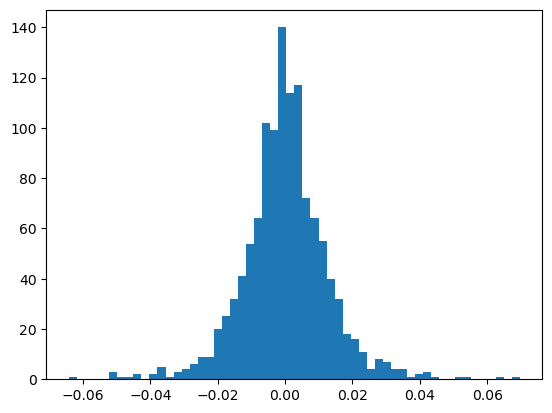

In [124]:
plt.hist(data["Target"], bins='auto')

Looking at the data statistics, histogram, skew and kurtosis, the returns are fairly normally distributed. This motivates us for trying to fit linear regression as a simple baseline:

## Simple Linear Regression

In [125]:
## Since provided test data only has 2 rows, we create our own split:
train_data = data.iloc[:1000, :]
test_data = data.iloc[1000:, :]

Int64Index([      0,    1865,    3730,    5595,    7460,    9325,   11190,
              13055,   14920,   16785,
            ...
            2312531, 2314531, 2316531, 2318531, 2320531, 2322531, 2324531,
            2326531, 2328531, 2330531],
           dtype='int64', length=1201)

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# cols = ["Open", "High", "Low", "Close"]
cols = ["Close"]
train_X = train_data[cols]
train_Y = train_data["Target"].values
test_X = test_data[cols]
test_Y = test_data["Target"].values

train_X = sm.add_constant(train_X)
test_X = sm.add_constant(test_X)
model = sm.OLS(train_Y, train_X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.719
Date:                Sun, 07 May 2023   Prob (F-statistic):             0.0995
Time:                        20:57:23   Log-Likelihood:                 2915.3
No. Observations:                1000   AIC:                            -5827.
Df Residuals:                     998   BIC:                            -5817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.695      0.0

In [142]:
train_y_preds = results.predict()
test_y_preds = results.predict(test_X)

In [143]:
train_corr = np.corrcoef(train_y_preds, train_Y)[0, 1]
test_corr = np.corrcoef(test_y_preds, test_Y)[0, 1]
print("Train corr is {}. Test corr is {}".format(train_corr, test_corr))

Train corr is 0.05212366987279747. Test corr is 0.18219545829607847


## ARIMA models

In [136]:
from statsmodels.tsa.stattools import adfuller
p_val = adfuller(data["Target"])[1]
print(p_val)
if p_val > 0.05:
    print("Non Stationary!")
else:
    print("Stationary!")

0.0
Stationary!


The data looks stationary so we can go ahead and try out ARIMA models.

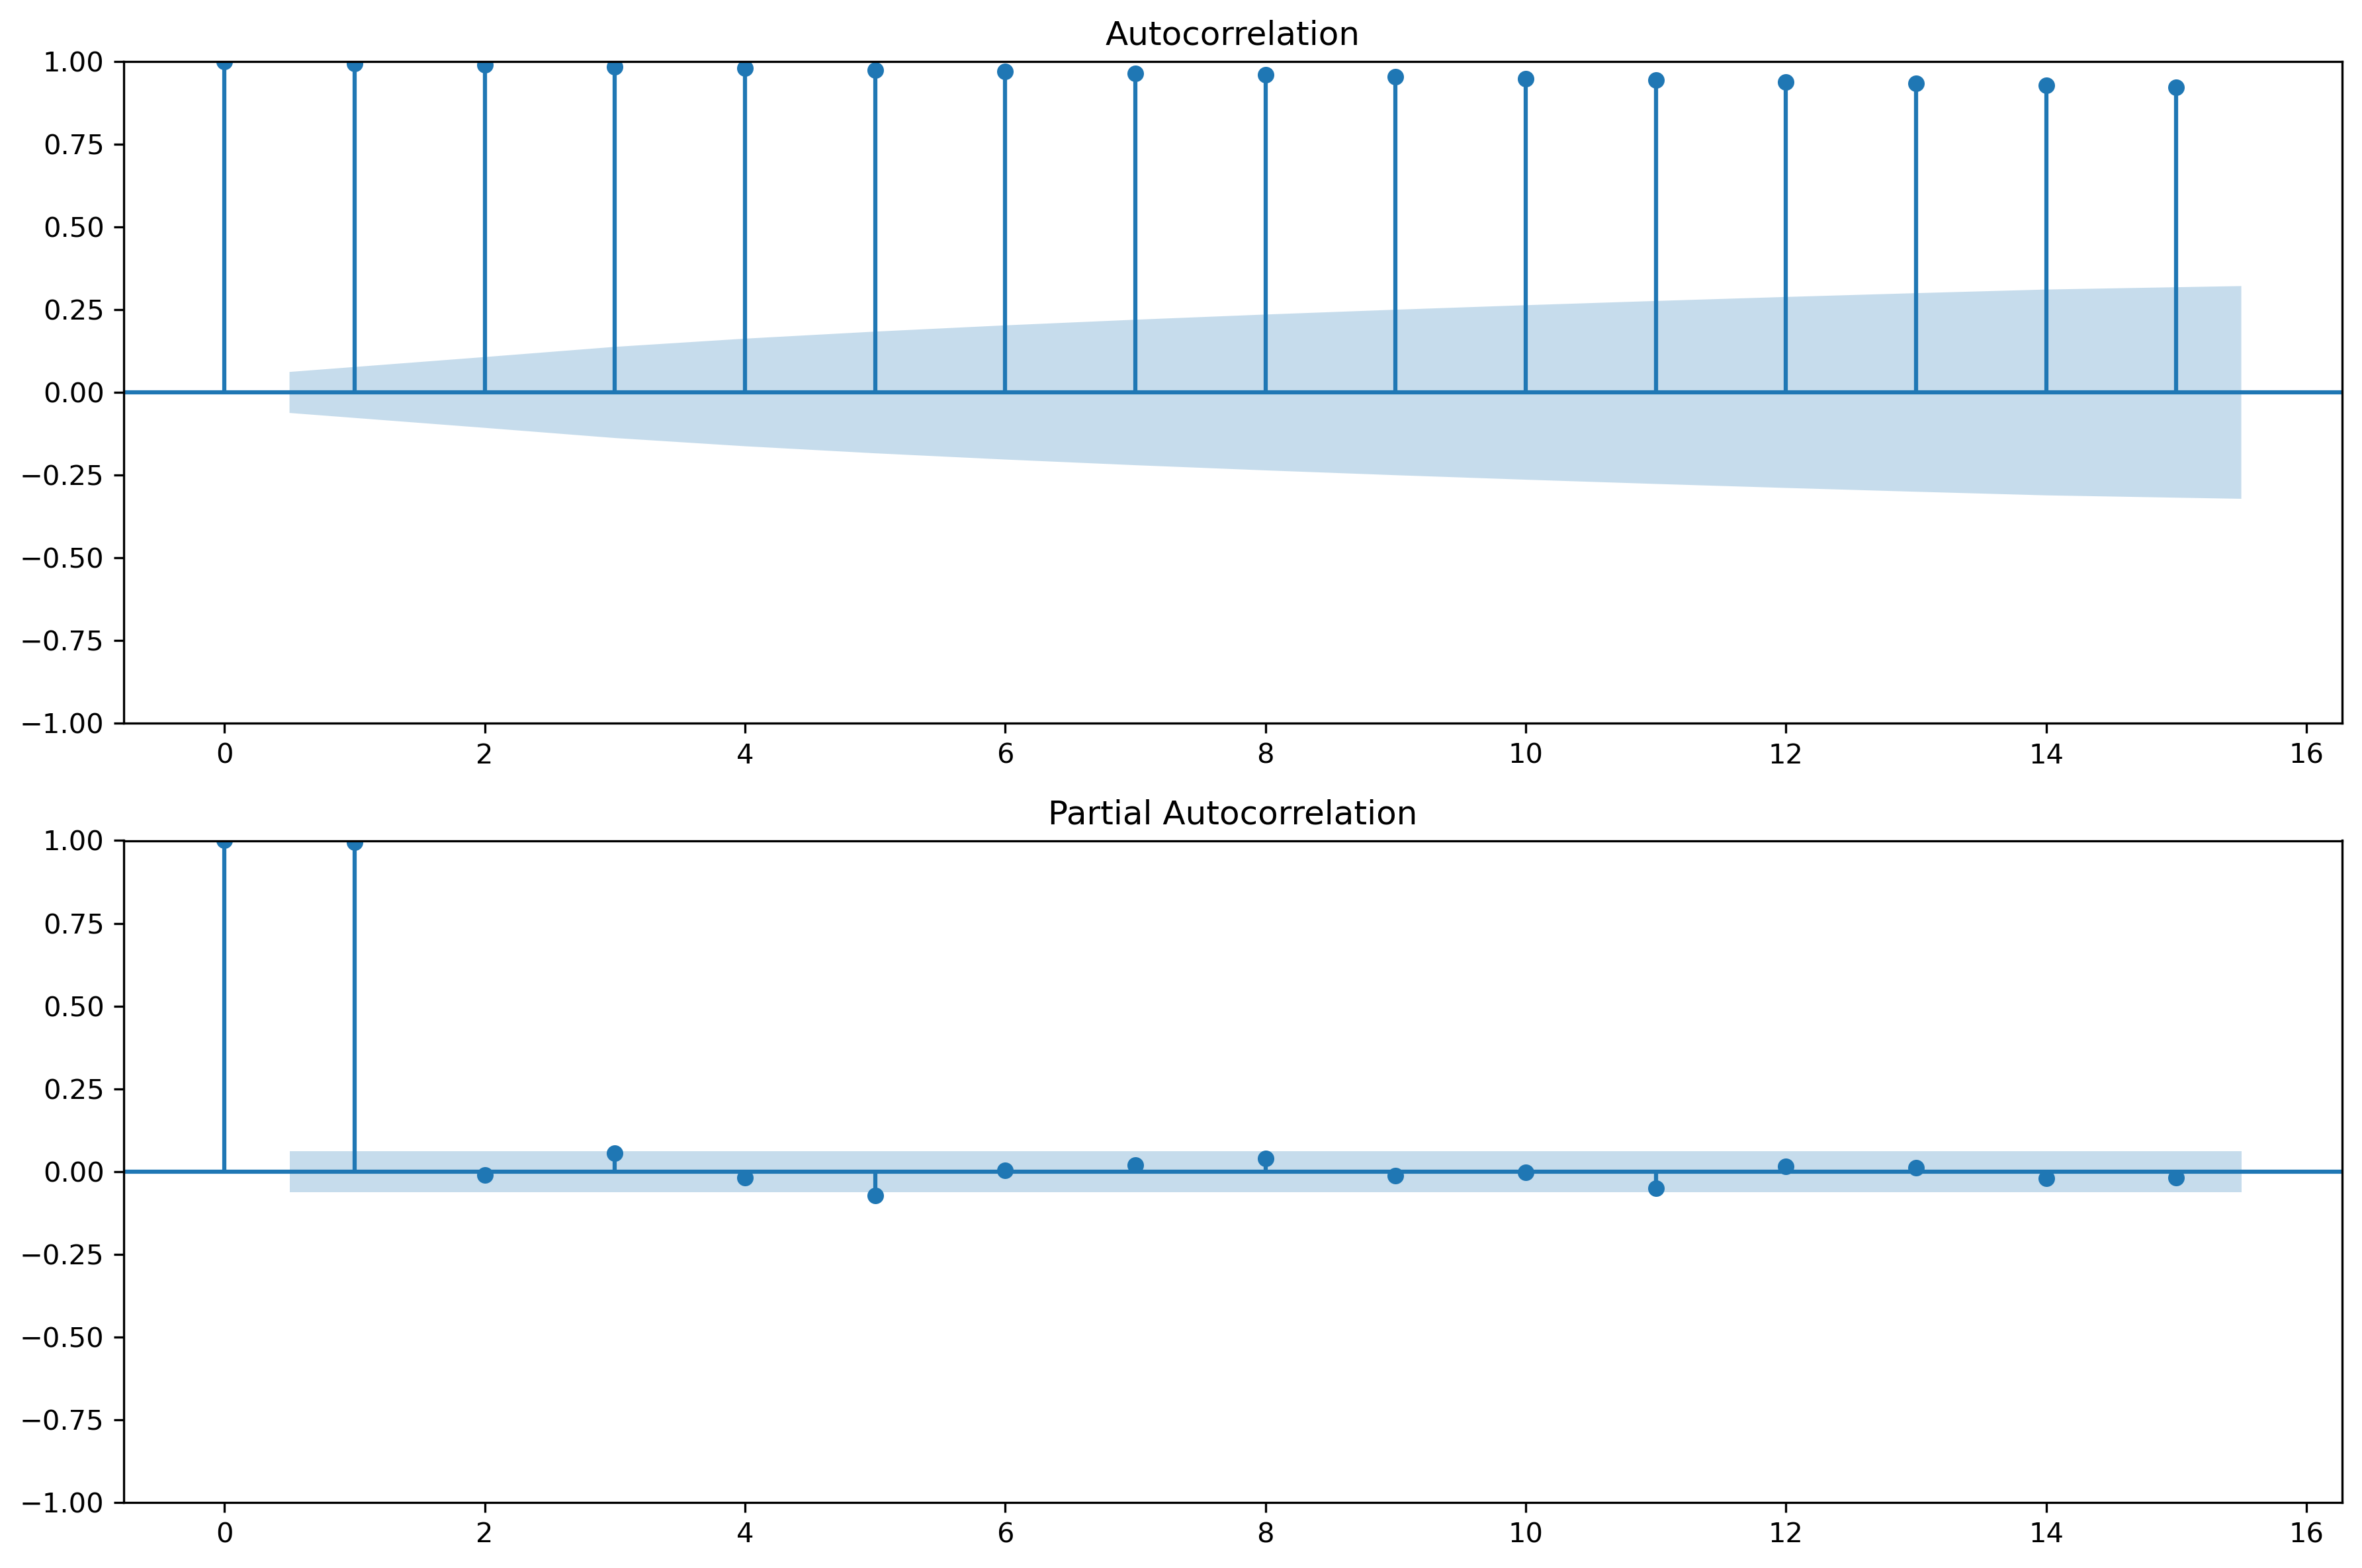

In [137]:
dat = train_data["Close"]
lag_acf = lag_pacf = 15
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 2*4), dpi=300)
plot_acf(dat, lags=lag_acf, ax=ax[0])
plot_pacf(dat, lags=lag_pacf, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

AR doesn't seem to be cutting off and PACF cuts off at lag 2. This motivates us to use ARIMA(2, 0, 0) models. We also add other ARIMA models and compare the train accuracies.

In [174]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

orders = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (2, 0, 1)]
for order in orders:
    model = ARIMA(train_Y, train_X.drop(columns=["const"]).to_numpy(), order=order).fit()
    train_preds = model.predict(disp=-1)
    test_preds = model.predict(exog=test_X.drop(columns=["const"]).to_numpy(), start=1000, end=1200)
    train_corr = np.corrcoef(train_preds, train_Y)[0, 1]
    test_corr = np.corrcoef(test_preds, test_Y)[0, 1]
    print("Train corr is {}. Test corr is {}".format(train_corr, test_corr))

/Users/satvikm/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/satvikm/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train corr is 0.052572481112755816. Test corr is 0.1829154300837467
Train corr is 0.07693063132202684. Test corr is 0.17488741779217512


/Users/satvikm/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train corr is 0.07693879049468781. Test corr is 0.175324388849775
Train corr is 0.07692651304443382. Test corr is 0.17533274094039997


/Users/satvikm/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0) seems to be the best model with higher train correlation and comparable test correlation.